In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import scipy
import pandas as pd
from skimage import data, io, filters
from PIL import Image
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
import  time

In [3]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
root = '/kaggle/input/hw3dataset/dataset'

In [4]:
####################################################################################
############################Data loader##########################################
####################################################################################
class AnimalDataset(Dataset):
    # TODO:
    # Define constructor for AnimalDataset class
    # HINT: You can pass processed data samples and their ground truth values as parameters 
    def __init__(self, x_data, y_data):
        self.data = x_data
        self.labels = y_data

    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.data)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        _x = self.data[index]
        _y = self.labels[index]
        return _x, _y


def get_dataset(root):
    # Read dataset files
    data_paths = []
    root_list = os.listdir(root)
    index = 0
    for i in range(len(root_list)):
        if root_list[i] != '.directory':
            data_paths.append((index, root_list[i],os.listdir(f'{root}/' + root_list[i])))
        else:
            continue
        index += 1

    x_data = []
    y_data = []
    for i in range(len(data_paths)):
        for j in range(len(data_paths[i][2])):
            x_data.append(f'{root}/' +  data_paths[i][1] + '/' + data_paths[i][2][j])
            y_data.append(data_paths[i][0])
    
    train_x, train_y = [], []
    val_x, val_y = [], []
    test_x, test_y = [], []
    aux = 0
    for i in range(len(x_data)):
        if i % 200 == 0 and i != 0:
            aux = 0
        path = x_data[i]
        data = Image.open(path).convert('L') # reading
        data = np.asarray(data).astype(float)
        data = normalize(data.flatten(), flatten = True)   # normalizing and flattening
        if aux < 140:
            train_x.append(data)
            train_y.append(y_data[i])
        elif aux < 160:
            val_x.append(data)
            val_y.append(y_data[i])
        else:
            test_x.append(data)
            test_y.append(y_data[i])
        aux += 1
            
    train_dataset = AnimalDataset(train_x, train_y)
    val_dataset = AnimalDataset(val_x, val_y)
    test_dataset = AnimalDataset(test_x, test_y)
    
    return train_dataset, val_dataset, test_dataset

def normalize(v, flatten = False):
    if flatten:
        v_min = v.min(axis=(0), keepdims=True)
        v_max = v.max(axis=(0), keepdims=True)
    else:
        v_min = v.min(axis=(0, 1), keepdims=True)
        v_max = v.max(axis=(0, 1), keepdims=True)
    return (v - v_min)/(v_max - v_min)

In [5]:
####################################################################################
############################ MLP approach ##########################################
####################################################################################
class FNet(nn.Module):
    '''Define your neural network'''
    def __init__(self): 
    # you can add any additional parameters you want 
    # TODO:
    # You should create your neural network here
        super().__init__()
        self.linear1 = nn.Linear(10000, 1000)
        self.hidden = nn.Linear(1000, 500)
        self.linear2 = nn.Linear(500, 10)
     
    def forward(self, X): 
    # you can add any additional parameters you want
    # TODO:
    # Forward propagation implementation should be here
        h1_relu = F.relu(self.linear1(X))
        h2_relu = F.relu(self.hidden(h1_relu))
        y_pred = F.log_softmax(self.linear2(h2_relu), dim = 1)
        #print(y_pred)
        return y_pred

In [6]:
#HINT: note that your training time should not take many days.
from torch import autograd
#TODO:
#Pick your hyper parameters
plot1 = []
plot2 = []
max_epoch = 30
train_batch = 3
test_batch = 10


learning_rate = 0.0001

use_gpu = torch.cuda.is_available()

def nn_main(): # you are free to change parameters
    params = {'batch_size': train_batch,
          'shuffle': True}
    
    (train_dataset, val_dataset, test_dataset) = get_dataset(root)
    # Create train dataset loader
    train_loader = DataLoader(train_dataset, **params)
    # Create validation dataset loader
    val_loader = DataLoader(val_dataset, **params)
    # Create test dataset loader
    test_loader = DataLoader(test_dataset, **params)
    
    # initialize your GENet neural network
    model = FNet()
    
    # define your loss function
    criterion = nn.NLLLoss(reduction = 'sum')
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-04) # you can play with momentum and weight_decay parameters as well
    
    if use_gpu:
        model.cuda()
    # start training
    # for each epoch calculate validation performance
    # save best model according to validation performance
    best_acc = 0
    for epoch in range(1, max_epoch+1):
        nn_train(epoch, model, criterion, optimizer, train_loader)
        acc = nn_test(model, val_loader, epoch)
        if acc.float() > best_acc:
            best_acc = acc.float()
            print("best acc: ", best_acc)
            torch.save(model.state_dict(), "./best_model.pth")
        #break
    return (model, test_loader)
    
''' Train your network for a one epoch '''
def nn_train(epoch, model, criterion, optimizer, loader):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(loader):
        data, target = Variable(data), Variable(target)
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data.float())
        #print("target: ", target)#, " output: ", output)       
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset), 100. * batch_idx / len(loader), loss.item()))
            plot1.append( (batch_idx * len(data), loss.item(), 100. * correct/len(loader.dataset)))


''' Test&Validate your network '''
def nn_test(model, loader, epoch = 0): # you are free to change parameters

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, labels in loader:
            # TODO:
            # Implement test code
            data, labels = Variable(data), Variable(labels)
            if use_gpu:
                data, labels = data.cuda(), labels.cuda()
            output = model(data.float())
            
            test_loss += F.nll_loss(output, labels).item()
            
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
            
        test_loss /= len(loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(loader.dataset),
            100. * correct / len(loader.dataset)))
        if epoch > 0:
            plot2.append( (epoch, test_loss, 100. * correct / len(loader.dataset)) )
    return 100. * correct / len(loader.dataset)
        

In [7]:
nn_model, test_loader = nn_main()

Train Epoch: 1 [0/1400 (0%)]	Loss: 6.910155
Train Epoch: 1 [150/1400 (11%)]	Loss: 6.754807
Train Epoch: 1 [300/1400 (21%)]	Loss: 7.182049
Train Epoch: 1 [450/1400 (32%)]	Loss: 6.839528
Train Epoch: 1 [600/1400 (43%)]	Loss: 7.204783
Train Epoch: 1 [750/1400 (54%)]	Loss: 6.691467
Train Epoch: 1 [900/1400 (64%)]	Loss: 6.951475
Train Epoch: 1 [1050/1400 (75%)]	Loss: 6.931742
Train Epoch: 1 [1200/1400 (86%)]	Loss: 6.852136
Train Epoch: 1 [1350/1400 (96%)]	Loss: 7.248693

Test set: Average loss: 0.7702, Accuracy: 22/200 (11%)

best acc:  tensor(11.)
Train Epoch: 2 [0/1400 (0%)]	Loss: 7.069388
Train Epoch: 2 [150/1400 (11%)]	Loss: 7.094358
Train Epoch: 2 [300/1400 (21%)]	Loss: 6.919061
Train Epoch: 2 [450/1400 (32%)]	Loss: 6.838223
Train Epoch: 2 [600/1400 (43%)]	Loss: 6.980814
Train Epoch: 2 [750/1400 (54%)]	Loss: 6.541141
Train Epoch: 2 [900/1400 (64%)]	Loss: 7.373672
Train Epoch: 2 [1050/1400 (75%)]	Loss: 6.872931
Train Epoch: 2 [1200/1400 (86%)]	Loss: 6.693069
Train Epoch: 2 [1350/1400 (9

Train Epoch: 16 [450/1400 (32%)]	Loss: 5.222742
Train Epoch: 16 [600/1400 (43%)]	Loss: 4.638769
Train Epoch: 16 [750/1400 (54%)]	Loss: 3.642300
Train Epoch: 16 [900/1400 (64%)]	Loss: 6.412096
Train Epoch: 16 [1050/1400 (75%)]	Loss: 5.508221
Train Epoch: 16 [1200/1400 (86%)]	Loss: 6.418805
Train Epoch: 16 [1350/1400 (96%)]	Loss: 6.203789

Test set: Average loss: 0.7564, Accuracy: 34/200 (17%)

Train Epoch: 17 [0/1400 (0%)]	Loss: 4.974997
Train Epoch: 17 [150/1400 (11%)]	Loss: 7.783492
Train Epoch: 17 [300/1400 (21%)]	Loss: 4.767600
Train Epoch: 17 [450/1400 (32%)]	Loss: 4.439266
Train Epoch: 17 [600/1400 (43%)]	Loss: 5.024412
Train Epoch: 17 [750/1400 (54%)]	Loss: 5.450161
Train Epoch: 17 [900/1400 (64%)]	Loss: 6.482219
Train Epoch: 17 [1050/1400 (75%)]	Loss: 4.783659
Train Epoch: 17 [1200/1400 (86%)]	Loss: 4.594899
Train Epoch: 17 [1350/1400 (96%)]	Loss: 5.879550

Test set: Average loss: 0.7541, Accuracy: 43/200 (22%)

Train Epoch: 18 [0/1400 (0%)]	Loss: 7.409831
Train Epoch: 18 [150/1

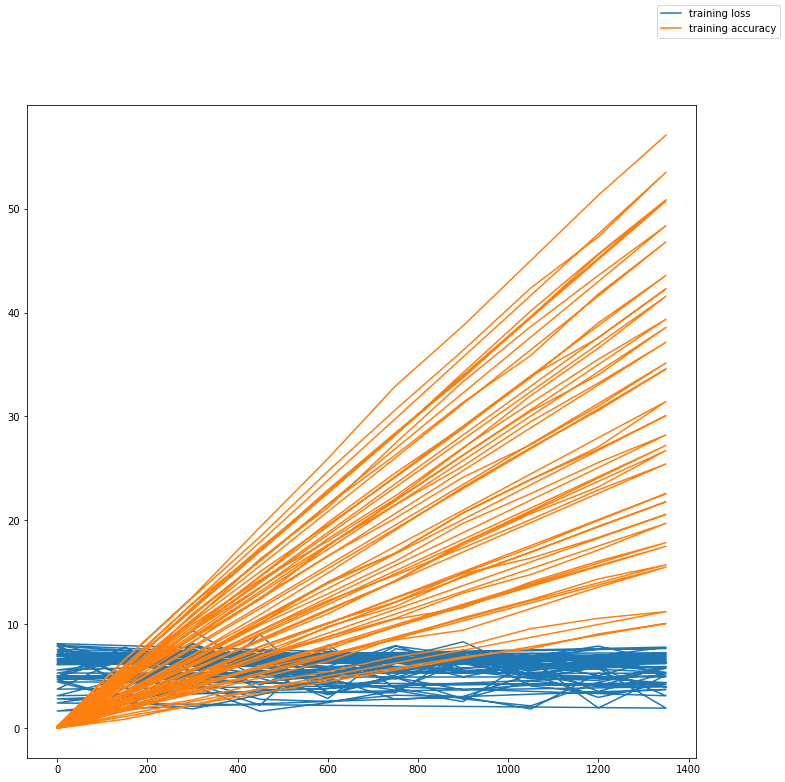

In [8]:
#### PLOTTING RESULTS DURING TRAINING #### 
batches = np.zeros(len(plot1))
training_loss = np.zeros(len(plot1))
training_acc = np.zeros(len(plot1))
for i in range(len(plot1)):
    batches[i] = plot1[i][0]
    training_loss[i] = plot1[i][1]
    training_acc[i] = plot1[i][2]
fig = plt.figure(figsize=(12,12))
plt.plot(batches, training_loss, label = 'training loss') 
plt.plot(batches, training_acc, label = 'training accuracy') 
fig.legend()

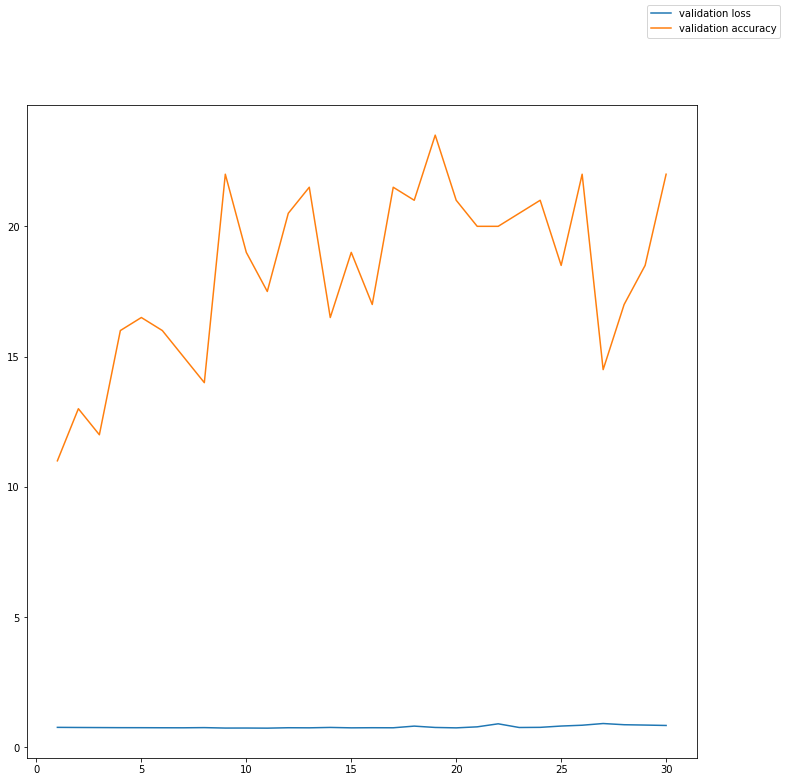

In [9]:
epochs = np.zeros(len(plot2))
val_loss = np.zeros(len(plot2))
val_acc = np.zeros(len(plot2))
for i in range(len(plot2)):
    epochs[i] = plot2[i][0]
    val_loss[i] = plot2[i][1]
    val_acc[i] = plot2[i][2]
fig = plt.figure(figsize=(12,12))
plt.plot(epochs, val_loss, label = 'validation loss') 
plt.plot(epochs, val_acc, label = 'validation accuracy')
fig.legend()

In [10]:
#### TESTING BEST MODEL ####
nn_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [11]:
nn_test(nn_model, test_loader)


Test set: Average loss: 0.7725, Accuracy: 84/400 (21%)



tensor(21.)

In [19]:
##################################################################################################
##################################################################################################
########################################## CNN MODEL ##########################################
##################################################################################################
##################################################################################################
class AnimalDataset(Dataset):
    # TODO:
    # Define constructor for AnimalDataset class
    # HINT: You can pass processed data samples and their ground truth values as parameters 
    def __init__(self, x_data, y_data):
        self.data = x_data
        self.labels = y_data

    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.data)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        _x = self.data[index]
        _x = np.transpose(_x, (2, 1, 0))
        _y = self.labels[index]
        return _x, _y


def get_dataset(root, transform = None):
    # Read dataset files
    data_paths = []
    root_list = os.listdir(root)
    index = 0
    for i in range(len(root_list)):
        if root_list[i] != '.directory':
            data_paths.append((index, root_list[i],os.listdir(f'{root}/' + root_list[i])))
        else:
            continue
        index += 1

    x_data = []
    y_data = []
    for i in range(len(data_paths)):
        for j in range(len(data_paths[i][2])):
            x_data.append(f'{root}/' +  data_paths[i][1] + '/' + data_paths[i][2][j])
            y_data.append(data_paths[i][0])
    
    train_x, train_y = [], []
    val_x, val_y = [], []
    test_x, test_y = [], []
    aux = 0
    for i in range(len(x_data)):
        if i % 200 == 0 and i != 0:
            aux = 0
        path = x_data[i]
        data = Image.open(path) # reading
        if transform is not None:
            data = transform(data)
        data = np.array(data).astype(float)
        data = normalize(data)   #  normalize
        if aux < 140:
            train_x.append(data)
            train_y.append(y_data[i])
        elif aux < 160:
            val_x.append(data)
            val_y.append(y_data[i])
        else:
            test_x.append(data)
            test_y.append(y_data[i])
        aux += 1
            
    train_dataset = AnimalDataset(train_x, train_y)
    val_dataset = AnimalDataset(val_x, val_y)
    test_dataset = AnimalDataset(test_x, test_y)
    
    return train_dataset, val_dataset, test_dataset    

In [20]:
class ConvNet(nn.Module):
    '''Define your neural network'''
    def __init__(self): # you can add any additional parameters you want 
    # TODO:
    # You should create your neural network here
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(32, 64,3, stride = 1, padding = 0)
        self.conv3 = nn.Conv2d(64, 128, 3, stride = 1, padding = 0)
        self.mp = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(128*23*23, 10)
    def forward(self, X): # you can add any additional parameters you want
    # TODO:
    # Forward propagation implementation should be here
        in_size = X.size(0) # getting batch size
        X = F.relu(self.conv1(X)) # 2
        X = F.relu(self.conv2(X)) # 4
        X = self.mp(X) # 5
        X = F.relu(self.conv3(X)) # 7
        X = self.mp(X) # 8
        X = X.view(in_size, -1)
        #print(X.shape)
        X = self.fc(X)
        return F.log_softmax(X, dim = 0)
    

In [23]:
# HINT: note that your training time should not take many days.

# TODO:
# Pick your hyper parameters
max_epoch = 30
train_batch = 5
test_batch = 10
learning_rate = 0.0001
plot1 = []
plot2 = []

use_gpu = torch.cuda.is_available()

def main(): # you are free to change parameters
    train_params = {'batch_size': train_batch,
          'shuffle': True}
    
    test_params = {'batch_size': test_batch,
          'shuffle': True}
    
    (train_dataset, val_dataset, test_dataset) = get_dataset(root)
    # Create train dataset loader
    train_loader = DataLoader(train_dataset, **train_params)
    # Create validation dataset loader
    val_loader = DataLoader(val_dataset, **test_params)
    # Create test dataset loader
    test_loader = DataLoader(test_dataset, **test_params)
    
    # initialize your Conv neural network
    model = ConvNet()
    if use_gpu:
        model.cuda()
    
    # define your loss function
    criterion = nn.NLLLoss(reduction='sum')
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-04) # you can play with momentum and weight_decay parameters as well
    
    # start training
    # for each epoch calculate validation performance
    # save best model according to validation performance
    
    #for epoch in range(max_epoch):   
    best_acc = 0
    for epoch in range(1, max_epoch+1):
        train(epoch, model, criterion, optimizer, train_loader)
        acc = test(model, val_loader, epoch)
        if acc.float() > best_acc:
            best_acc = acc.float()
            print("best acc: ", best_acc)
            torch.save(model.state_dict(), "./best_conv_model.pth")
    
    return (model, test_loader)
    
''' Train your network for a one epoch '''
def train(epoch, model, criterion, optimizer, loader): # you are free to change parameters
    model.train()
    correct = 0
    since = time.time()
    for batch_idx, (data, target) in enumerate(loader):
        #print(data.shape)
        data, target = Variable(data), Variable(target)
        
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data.float())     
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % 50 == 0:
            time_el = time.time() - since
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset), 100. * batch_idx / len(loader), loss.item()))
            print("batch time: ",  time_el)
            print("Training Accuracy", 100. * correct/len(loader.dataset))
            plot1.append( (batch_idx * len(data), loss.item(), 100. * correct/len(loader.dataset)))
            since = time.time()

''' Test&Validate your network '''
def test(model, loader, epoch = 0): # you are free to change parameters

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, labels in loader:
            # TODO:
            # Implement test code
            data, labels = Variable(data), Variable(labels)
            if use_gpu:
                data, labels = data.cuda(), labels.cuda()
                
            output = model(data.float())
            
            test_loss += F.nll_loss(output, labels).item()
            
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
            
        test_loss /= len(loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(loader.dataset),
            100. * correct / len(loader.dataset)))
        if epoch > 0:
            plot2.append( (epoch, test_loss, 100. * correct / len(loader.dataset)) )
    return 100. * correct / len(loader.dataset)
        

In [24]:
######################################################################
###################### train model with validation############################################
(cnn_model, test_loader)  = main()

Train Epoch: 1 [0/1400 (0%)]	Loss: 8.047940
batch time:  0.0061147212982177734
Training Accuracy tensor(0.)
Train Epoch: 1 [250/1400 (18%)]	Loss: 8.100859
batch time:  0.24765539169311523
Training Accuracy tensor(2.1429)
Train Epoch: 1 [500/1400 (36%)]	Loss: 7.806859
batch time:  0.22720003128051758
Training Accuracy tensor(4.4286)
Train Epoch: 1 [750/1400 (54%)]	Loss: 7.689774
batch time:  0.2260284423828125
Training Accuracy tensor(7.7143)
Train Epoch: 1 [1000/1400 (71%)]	Loss: 7.737668
batch time:  0.22687983512878418
Training Accuracy tensor(10.2857)
Train Epoch: 1 [1250/1400 (89%)]	Loss: 9.016756
batch time:  0.23032903671264648
Training Accuracy tensor(13.5714)

Test set: Average loss: 0.2262, Accuracy: 29/200 (14%)

best acc:  tensor(14.5000)
Train Epoch: 2 [0/1400 (0%)]	Loss: 6.911294
batch time:  0.004758358001708984
Training Accuracy tensor(0.)
Train Epoch: 2 [250/1400 (18%)]	Loss: 7.716783
batch time:  0.2277207374572754
Training Accuracy tensor(3.4286)
Train Epoch: 2 [500/1


Test set: Average loss: 0.2596, Accuracy: 51/200 (26%)

Train Epoch: 12 [0/1400 (0%)]	Loss: 4.005345
batch time:  0.004789590835571289
Training Accuracy tensor(0.2143)
Train Epoch: 12 [250/1400 (18%)]	Loss: 0.561495
batch time:  0.22335124015808105
Training Accuracy tensor(11.3571)
Train Epoch: 12 [500/1400 (36%)]	Loss: 2.009135
batch time:  0.23573899269104004
Training Accuracy tensor(21.7857)
Train Epoch: 12 [750/1400 (54%)]	Loss: 4.794521
batch time:  0.22159075736999512
Training Accuracy tensor(32.4286)
Train Epoch: 12 [1000/1400 (71%)]	Loss: 3.931843
batch time:  0.22446918487548828
Training Accuracy tensor(42.4286)
Train Epoch: 12 [1250/1400 (89%)]	Loss: 3.667263
batch time:  0.2236921787261963
Training Accuracy tensor(53.3571)

Test set: Average loss: 0.2639, Accuracy: 53/200 (26%)

Train Epoch: 13 [0/1400 (0%)]	Loss: 2.110850
batch time:  0.005203723907470703
Training Accuracy tensor(0.2143)
Train Epoch: 13 [250/1400 (18%)]	Loss: 0.709732
batch time:  0.2371978759765625
Traini


Test set: Average loss: 0.2730, Accuracy: 56/200 (28%)

Train Epoch: 23 [0/1400 (0%)]	Loss: 1.500275
batch time:  0.004829883575439453
Training Accuracy tensor(0.2143)
Train Epoch: 23 [250/1400 (18%)]	Loss: 3.185509
batch time:  0.2250378131866455
Training Accuracy tensor(13.4286)
Train Epoch: 23 [500/1400 (36%)]	Loss: 0.503890
batch time:  0.2266063690185547
Training Accuracy tensor(27.1429)
Train Epoch: 23 [750/1400 (54%)]	Loss: 1.994279
batch time:  0.23318886756896973
Training Accuracy tensor(40.8571)
Train Epoch: 23 [1000/1400 (71%)]	Loss: 2.148438
batch time:  0.22456884384155273
Training Accuracy tensor(54.6429)
Train Epoch: 23 [1250/1400 (89%)]	Loss: 0.115677
batch time:  0.22527337074279785
Training Accuracy tensor(68.7143)

Test set: Average loss: 0.2985, Accuracy: 52/200 (26%)

Train Epoch: 24 [0/1400 (0%)]	Loss: 3.140913
batch time:  0.005017757415771484
Training Accuracy tensor(0.2143)
Train Epoch: 24 [250/1400 (18%)]	Loss: 3.478901
batch time:  0.22506952285766602
Traini

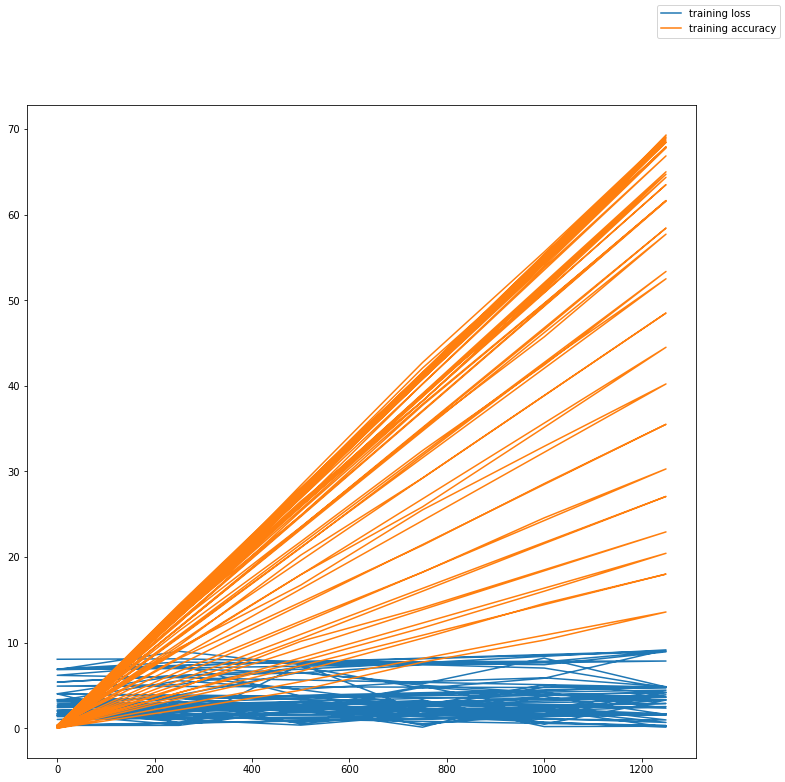

In [25]:
#### PLOTTING RESULTS DURING TRAINING #### 
batches = np.zeros(len(plot1))
training_loss = np.zeros(len(plot1))
training_acc = np.zeros(len(plot1))
for i in range(len(plot1)):
    batches[i] = plot1[i][0]
    training_loss[i] = plot1[i][1]
    training_acc[i] = plot1[i][2]
fig = plt.figure(figsize=(12,12))
plt.plot(batches, training_loss, label = 'training loss') 
plt.plot(batches, training_acc, label = 'training accuracy') 
fig.legend()

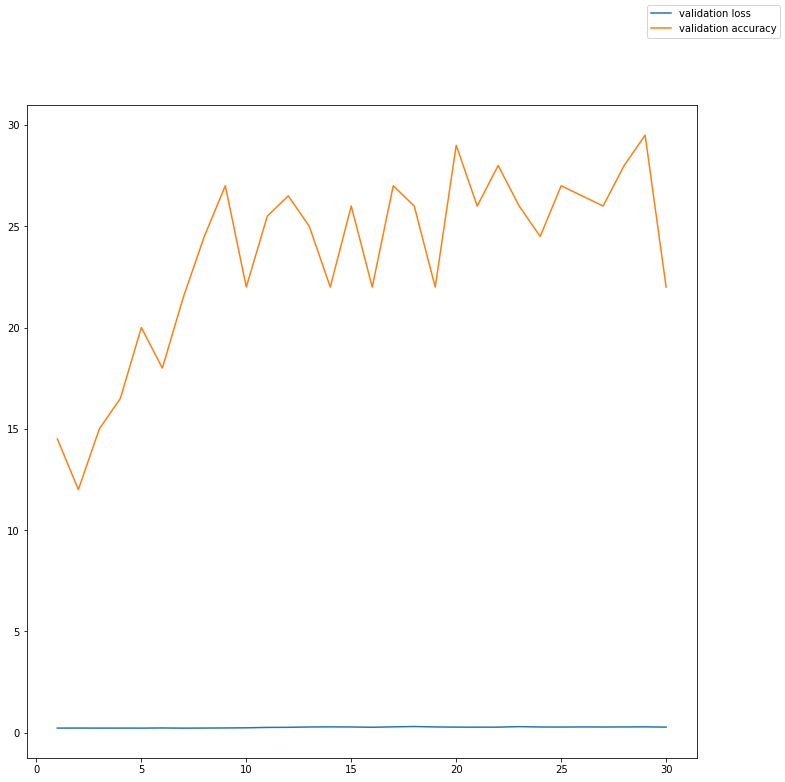

In [26]:
epochs = np.zeros(len(plot2))
val_loss = np.zeros(len(plot2))
val_acc = np.zeros(len(plot2))
for i in range(len(plot2)):
    epochs[i] = plot2[i][0]
    val_loss[i] = plot2[i][1]
    val_acc[i] = plot2[i][2]
fig = plt.figure(figsize=(12,12))
plt.plot(epochs, val_loss, label = 'validation loss') 
plt.plot(epochs, val_acc, label = 'validation accuracy')
fig.legend()

In [27]:
##################################################################
########################## test model ############################
cnn_model.load_state_dict(torch.load('best_conv_model.pth'))

<All keys matched successfully>

In [28]:
test(cnn_model, test_loader)


Test set: Average loss: 0.2676, Accuracy: 112/400 (28%)



tensor(28.)

In [33]:
def get_tensor(model):
    lst = list(model.named_parameters())
    return lst[0][1].cpu().detach().numpy()

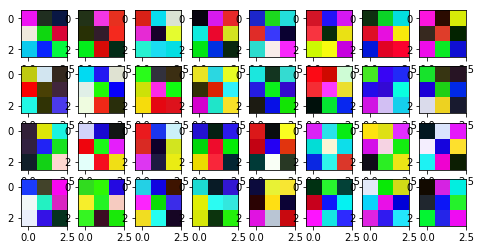

In [34]:
## Weight visualisation ##
tensor = get_tensor(cnn_model)
num_cols = 8
num_kernels = tensor.shape[0]
num_rows = 1+ num_kernels // num_cols
fig = plt.figure(figsize=(num_cols,num_rows))
for i in range(tensor.shape[0]):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow((tensor[i] * 255.).astype(np.uint8))

plt.show()

In [35]:
######################################################################
########################### TRANSFER LEARNING #####################
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [36]:
inception_v3 = torchvision.models.inception_v3(pretrained=True)
set_parameter_requires_grad(inception_v3, True)
# Handle the auxilary net
num_ftrs = inception_v3.AuxLogits.fc.in_features
inception_v3.AuxLogits.fc = nn.Linear(num_ftrs, 10)
# Handle the primary net
num_ftrs = inception_v3.fc.in_features
inception_v3.fc = nn.Linear(num_ftrs,10)

In [40]:
def train_model(model, train_loader, val_loader, criterion, optimizer, use_gpu):
    num_epochs = 25
    best_acc = 0.0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()   # Set model to evaluate mode        
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for batch_idx, (inputs, labels) in enumerate(train_loader):

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            #with torch.set_grad_enabled():
            outputs, aux_outputs = model(inputs.float())
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4*loss2

            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset)

            #print( 'Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(inputs), len(train_loader.dataset), 100. * batch_idx / len(train_loader), epoch_loss))
                print("Epoch Accuracy: ", epoch_acc)
                
        acc = test_model(model, val_loader, use_gpu)
        if acc.float() > best_acc:
            best_acc = acc.float()
            print("best acc: ", best_acc)
            torch.save(model.state_dict(), "./best_pretrained.pth")
    
def test_model(model, loader, use_gpu): # you are free to change parameters

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, labels in loader:
            # TODO:
            # Implement test code
            data, labels = Variable(data), Variable(labels)
            if use_gpu:
                data, labels = data.cuda(), labels.cuda()
                
            output = model(data.float())
            
            test_loss += F.nll_loss(output, labels).item()
            
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
            
        test_loss /= len(loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(loader.dataset),
            100. * correct / len(loader.dataset)))
    return 100. * correct / len(loader.dataset)
        

In [41]:
max_epoch = 30
train_batch = 5
test_batch = 10
learning_rate = 0.0001

use_gpu = torch.cuda.is_available()


transform = transforms.Compose([
        transforms.Resize(299)])

train_params = {'batch_size': train_batch,
          'shuffle': True}
    
test_params = {'batch_size': test_batch,
      'shuffle': True}

(train_dataset, val_dataset, test_dataset) = get_dataset(root,transform = transform)
# Create train dataset loader
train_loader = DataLoader(train_dataset, **train_params)
# Create validation dataset loader
val_loader = DataLoader(val_dataset, **test_params)
# Create test dataset loader
test_loader = DataLoader(test_dataset, **test_params)


In [42]:
device = torch.device("cuda:0" if use_gpu else "cpu")
inception_v3 = inception_v3.to(device)
params_to_update = inception_v3.parameters()

params_to_update = []
for name,param in inception_v3.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
        
optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [43]:
criterion = nn.CrossEntropyLoss()

train_model(inception_v3, train_loader, val_loader, criterion, optimizer, use_gpu)

Epoch 0/24
----------
Train Epoch: 0 [0/1400 (0%)]	Loss: 0.010638
Epoch Accuracy:  tensor(0., device='cuda:0', dtype=torch.float64)
Train Epoch: 0 [250/1400 (18%)]	Loss: 0.593161
Epoch Accuracy:  tensor(0.0186, device='cuda:0', dtype=torch.float64)
Train Epoch: 0 [500/1400 (36%)]	Loss: 1.122070
Epoch Accuracy:  tensor(0.0586, device='cuda:0', dtype=torch.float64)
Train Epoch: 0 [750/1400 (54%)]	Loss: 1.596019
Epoch Accuracy:  tensor(0.1229, device='cuda:0', dtype=torch.float64)
Train Epoch: 0 [1000/1400 (71%)]	Loss: 2.036409
Epoch Accuracy:  tensor(0.2007, device='cuda:0', dtype=torch.float64)
Train Epoch: 0 [1250/1400 (89%)]	Loss: 2.454508
Epoch Accuracy:  tensor(0.2836, device='cuda:0', dtype=torch.float64)

Test set: Average loss: -0.1015, Accuracy: 119/200 (60%)

best acc:  tensor(59.5000)
Epoch 1/24
----------
Train Epoch: 1 [0/1400 (0%)]	Loss: 0.007508
Epoch Accuracy:  tensor(0.0021, device='cuda:0', dtype=torch.float64)
Train Epoch: 1 [250/1400 (18%)]	Loss: 0.394908
Epoch Accura

Train Epoch: 10 [500/1400 (36%)]	Loss: 0.473744
Epoch Accuracy:  tensor(0.2464, device='cuda:0', dtype=torch.float64)
Train Epoch: 10 [750/1400 (54%)]	Loss: 0.698965
Epoch Accuracy:  tensor(0.3686, device='cuda:0', dtype=torch.float64)
Train Epoch: 10 [1000/1400 (71%)]	Loss: 0.936672
Epoch Accuracy:  tensor(0.4850, device='cuda:0', dtype=torch.float64)
Train Epoch: 10 [1250/1400 (89%)]	Loss: 1.202208
Epoch Accuracy:  tensor(0.5971, device='cuda:0', dtype=torch.float64)

Test set: Average loss: -0.3156, Accuracy: 145/200 (72%)

Epoch 11/24
----------
Train Epoch: 11 [0/1400 (0%)]	Loss: 0.005653
Epoch Accuracy:  tensor(0.0029, device='cuda:0', dtype=torch.float64)
Train Epoch: 11 [250/1400 (18%)]	Loss: 0.243265
Epoch Accuracy:  tensor(0.1221, device='cuda:0', dtype=torch.float64)
Train Epoch: 11 [500/1400 (36%)]	Loss: 0.512251
Epoch Accuracy:  tensor(0.2336, device='cuda:0', dtype=torch.float64)
Train Epoch: 11 [750/1400 (54%)]	Loss: 0.757780
Epoch Accuracy:  tensor(0.3571, device='cuda:

Train Epoch: 20 [1250/1400 (89%)]	Loss: 1.179249
Epoch Accuracy:  tensor(0.5879, device='cuda:0', dtype=torch.float64)

Test set: Average loss: -0.3685, Accuracy: 141/200 (70%)

Epoch 21/24
----------
Train Epoch: 21 [0/1400 (0%)]	Loss: 0.004625
Epoch Accuracy:  tensor(0.0021, device='cuda:0', dtype=torch.float64)
Train Epoch: 21 [250/1400 (18%)]	Loss: 0.200934
Epoch Accuracy:  tensor(0.1300, device='cuda:0', dtype=torch.float64)
Train Epoch: 21 [500/1400 (36%)]	Loss: 0.429615
Epoch Accuracy:  tensor(0.2550, device='cuda:0', dtype=torch.float64)
Train Epoch: 21 [750/1400 (54%)]	Loss: 0.659986
Epoch Accuracy:  tensor(0.3714, device='cuda:0', dtype=torch.float64)
Train Epoch: 21 [1000/1400 (71%)]	Loss: 0.905320
Epoch Accuracy:  tensor(0.4864, device='cuda:0', dtype=torch.float64)
Train Epoch: 21 [1250/1400 (89%)]	Loss: 1.150814
Epoch Accuracy:  tensor(0.5971, device='cuda:0', dtype=torch.float64)

Test set: Average loss: -0.3658, Accuracy: 139/200 (70%)

Epoch 22/24
----------
Train Epoc

In [44]:
inception_v3.load_state_dict(torch.load('best_pretrained.pth'))

<All keys matched successfully>

In [45]:
test_model(inception_v3, test_loader, use_gpu)


Test set: Average loss: -0.3439, Accuracy: 286/400 (72%)



tensor(71.5000)

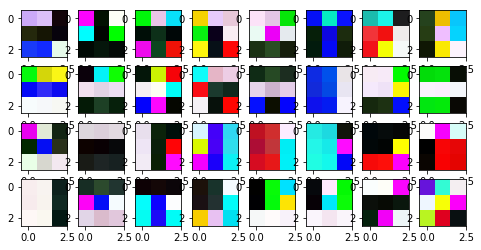

In [46]:
tensor = get_tensor(inception_v3)
num_cols = 8
num_kernels = tensor.shape[0]
num_rows = 1+ num_kernels // num_cols
fig = plt.figure(figsize=(num_cols,num_rows))
for i in range(tensor.shape[0]):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow((tensor[i] * 255.).astype(np.uint8))

plt.show()